# Proyek Pertama Machine Learning Terapan: Prediksi Harga Rumah

- **Nama:** Alif Nurhidayat
- **Email:** alifnurhidayatwork@gmail.com | mc189d5y0351@student.devacademy.id
- **ID Dicoding:** Alif Nurhidayat | MC189D5Y0351

## Pendahuluan
Proyek ini bertujuan untuk membangun model *machine learning* yang dapat memprediksi kualitas Harga Rumah (`SalePrice`) berdasarkan berbagai atributnya.

### 1. Impor & Persiapan Library yang Dibutuhkan

In [31]:
# Install dependencies as needed:
%pip install kaggle kagglehub pandas numpy matplotlib seaborn tensorflow scikit-learn joblib

In [32]:
# --- 0. Setup Kaggle API di Google Colab ---
# A. Unggah file kaggle.json Anda
from google.colab import files
print("Unggah file kaggle.json Anda:")
uploaded = files.upload()

# B. Pindahkan kaggle.json ke direktori yang benar dan set permission
# Pastikan hanya ada satu file kaggle.json yang diunggah
# dan namanya persis "kaggle.json"
if "kaggle.json" in uploaded:
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json berhasil diunggah dan permission disetel.")
else:
    print("Peringatan: File kaggle.json tidak ditemukan dalam unggahan.")

# C. Install library Kaggle
!pip install -q kaggle
print("Library Kaggle telah diinstal/diperbarui.")
print("\n")

Unggah file kaggle.json Anda:


Saving kaggle.json to kaggle (1).json
Peringatan: File kaggle.json tidak ditemukan dalam unggahan.
Library Kaggle telah diinstal/diperbarui.




In [33]:
# Impor library yang dibutuhkan
import pandas as pd # Untuk manipulasi dan analisis data tabular
import numpy as np # Untuk operasi numerik, terutama array
import matplotlib.pyplot as plt # Untuk membuat plot statis, animasi, dan interaktif
import seaborn as sns # Untuk membuat visualisasi data statistik yang menarik dan informatif
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split, GridSearchCV # Untuk membagi data dan melakukan tuning hyperparameter
from sklearn.preprocessing import StandardScaler, OneHotEncoder # Untuk standarisasi fitur numerik dan encoding fitur kategorikal
from sklearn.impute import SimpleImputer # Untuk menangani missing values
from sklearn.compose import ColumnTransformer # Untuk menerapkan transformer yang berbeda pada kolom data yang berbeda
from sklearn.pipeline import Pipeline # Untuk menggabungkan beberapa langkah pemrosesan dan pemodelan menjadi satu alur kerja
from sklearn.linear_model import LinearRegression # Model Regresi Linear
from sklearn.ensemble import RandomForestRegressor # Model Random Forest untuk regresi
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Metrik untuk evaluasi model regresi
import joblib # Untuk menyimpan dan memuat model machine learning

### 1. Pemuatan dan Pemahaman Data (Data Loading & Understanding)
Tahap ini adalah fondasi dari proyek machine learning. Kita akan mengunduh dataset dari Kaggle, memuatnya, melakukan inspeksi awal untuk memahami struktur dan isi data, serta mengidentifikasi variabel target.

### 1.1. Pengunduhan dan Pemuatan Dataset dari Kaggle
Dataset "House Prices - Advanced Regression Techniques" akan diunduh langsung dari Kaggle menggunakan Kaggle API, kemudian file train.csv akan dimuat ke dalam DataFrame Pandas.

In [34]:
# --- 1.1. Pengunduhan Dataset dari Kaggle dan Pemuatan Data ---
import pandas as pd
import numpy as np
import os
import zipfile

COMPETITION_NAME = "house-prices-advanced-regression-techniques"
FILE_TO_LOAD = "train.csv"
TARGET_COL = 'SalePrice'

print(f"--- Mengunduh Dataset: {COMPETITION_NAME} dari Kaggle ---")
# Perintah Kaggle API untuk mengunduh dataset kompetisi
!kaggle competitions download -c {COMPETITION_NAME}

# Nama file zip yang diunduh oleh Kaggle API
zip_file_name = f"{COMPETITION_NAME}.zip"

if os.path.exists(zip_file_name):
    print(f"File '{zip_file_name}' berhasil diunduh.")
    # Mengekstrak file yang dibutuhkan (train.csv) dari zip
    try:
        with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
            if FILE_TO_LOAD in zip_ref.namelist():
                zip_ref.extract(FILE_TO_LOAD)
                print(f"File '{FILE_TO_LOAD}' berhasil diekstrak.")
            else:
                print(f"Error: File '{FILE_TO_LOAD}' tidak ditemukan di dalam '{zip_file_name}'. Daftar file: {zip_ref.namelist()}")
                raise FileNotFoundError(f"'{FILE_TO_LOAD}' not in zip.")

        # Memuat data dari file CSV yang telah diekstrak
        if os.path.exists(FILE_TO_LOAD):
            df = pd.read_csv(FILE_TO_LOAD)
            print(f"Dataset '{FILE_TO_LOAD}' berhasil dimuat ke DataFrame.")
            print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}")
        else:
            print(f"Error: Gagal memuat '{FILE_TO_LOAD}' setelah ekstraksi.")
            raise FileNotFoundError(f"'{FILE_TO_LOAD}' not found after extraction.")
    except Exception as e:
        print(f"Error saat mengekstrak atau memuat file: {e}")
        raise e
else:
    print(f"Error: File '{zip_file_name}' tidak ditemukan setelah mencoba mengunduh.")
    print("Pastikan API Kaggle Anda terkonfigurasi dengan benar dan nama kompetisi tepat.")
    raise FileNotFoundError(f"'{zip_file_name}' not downloaded.")

print("\n")

--- Mengunduh Dataset: house-prices-advanced-regression-techniques dari Kaggle ---
house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)
File 'house-prices-advanced-regression-techniques.zip' berhasil diunduh.
File 'train.csv' berhasil diekstrak.
Dataset 'train.csv' berhasil dimuat ke DataFrame.
Jumlah baris: 1460, Jumlah kolom: 81




#### 1.2. Inspeksi Data Awal
Setelah data dimuat, kita akan melihat beberapa baris pertama (.head()) dan informasi umum (.info()) untuk memahami struktur, tipe data, dan keberadaan nilai null pada setiap kolom. Kolom 'Id' akan dijadikan sebagai index karena merupakan identifier unik dan tidak relevan sebagai fitur prediktif.

In [35]:
# --- Inspeksi Data Awal ---
print("--- 5 Baris Pertama Data ---")
print(df.head())
print("\n")

# Menjadikan kolom 'Id' sebagai index
if 'Id' in df.columns:
    df.set_index('Id', inplace=True)
    print("Kolom 'Id' telah dijadikan sebagai index.")
else:
    print("Peringatan: Kolom 'Id' tidak ditemukan.")
print("\n")


print("--- Informasi Dataset ---")
df.info()
print("\n")

--- 5 Baris Pertama Data ---
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  Sale

#### 1.3. Statistik Deskriptif
Statistik deskriptif (.describe() untuk numerik) memberikan gambaran tentang tendensi sentral, sebaran, dan nilai-nilai penting lainnya. Untuk fitur kategorikal, .value_counts() dapat digunakan untuk melihat frekuensi setiap kategori (akan dieksplorasi lebih lanjut di EDA). Ini membantu dalam memahami distribusi masing-masing fitur dan variabel target (SalePrice).

In [36]:
# --- Statistik Deskriptif ---
print("--- Statistik Deskriptif (Fitur Numerik Termasuk Target) ---")
numerical_features_all = df.select_dtypes(include=np.number).columns.tolist()
if numerical_features_all:
    print(df[numerical_features_all].describe().transpose()) # Transpose untuk tampilan lebih baik jika banyak kolom
else:
    print("Tidak ada fitur numerik yang valid ditemukan untuk statistik deskriptif.")
print("\n")

# Melihat jumlah nilai null per kolom untuk mendapatkan gambaran awal
print("--- Jumlah Nilai Null per Kolom ---")
print(df.isnull().sum().sort_values(ascending=False).head(20)) # Tampilkan 20 kolom dengan null terbanyak
print("\n")

--- Statistik Deskriptif (Fitur Numerik Termasuk Target) ---
                count           mean           std      min        25%  \
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324 

#### 1.4. Analisis Data Eksploratif (EDA) dengan Visualisasi
Visualisasi membantu kita memahami pola, tren, hubungan antar fitur, dan distribusi data secara lebih intuitif. Fokus utama EDA adalah pada variabel target SalePrice dan hubungannya dengan fitur-fitur lain.

##### 1.4.1. Distribusi Variabel Target (SalePrice) dan Fitur Numerik Penting
Histogram dan KDE (Kernel Density Estimate) plot digunakan untuk melihat distribusi variabel target dan beberapa fitur numerik yang dianggap penting berdasarkan deskripsi data atau korelasi awal.

--- Visualisasi Distribusi SalePrice dan Fitur Numerik Penting ---


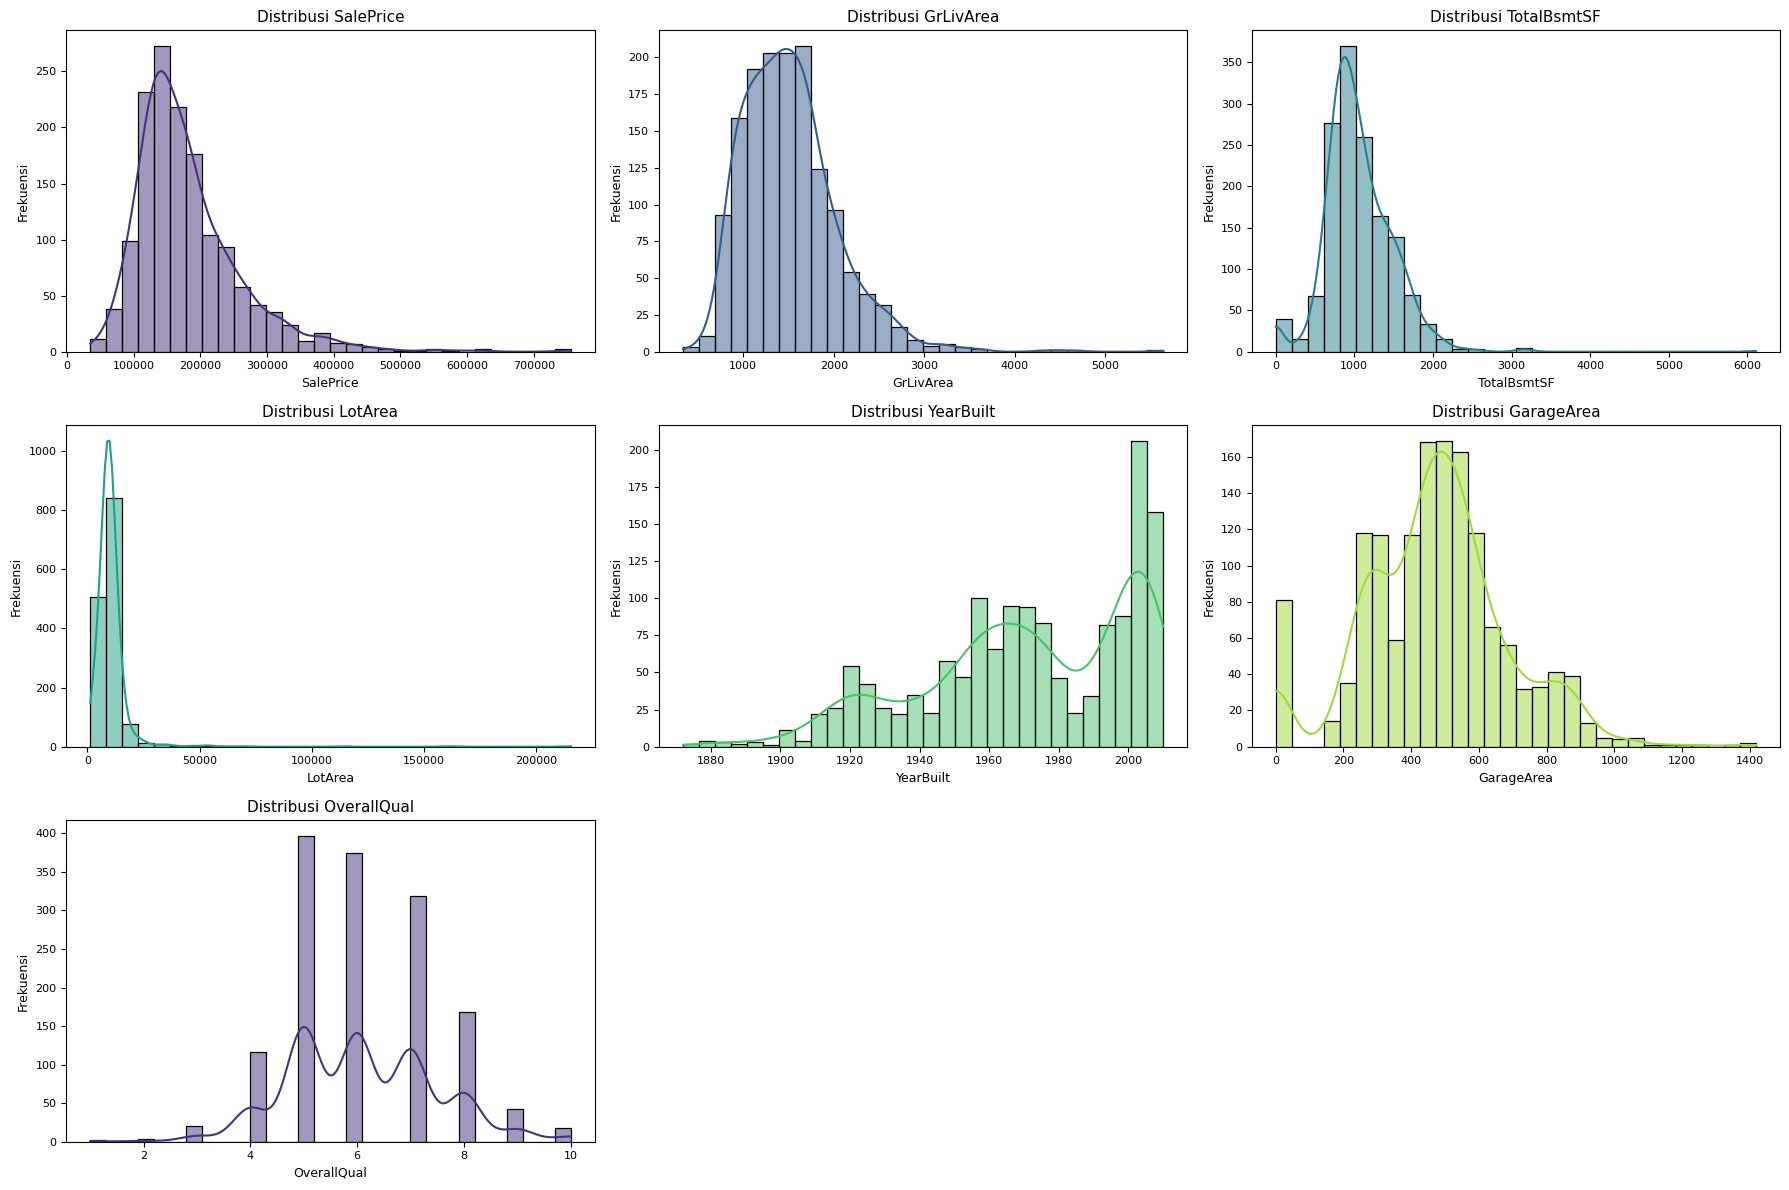

In [37]:
# --- Impor library visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Visualisasi Distribusi Fitur Numerik Pilihan (Termasuk Target) ---
print("--- Visualisasi Distribusi SalePrice dan Fitur Numerik Penting ---")

# Fitur numerik yang paling mungkin relevan dan target
numerical_features_for_dist_plot = [TARGET_COL, 'GrLivArea', 'TotalBsmtSF', 'LotArea', 'YearBuilt', 'GarageArea', 'OverallQual']
numerical_features_for_dist_plot = [col for col in numerical_features_for_dist_plot if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]


if numerical_features_for_dist_plot:
    plt.figure(figsize=(18, 12))
    num_plots = len(numerical_features_for_dist_plot)
    cols_plot = 3
    rows_plot = (num_plots + cols_plot - 1) // cols_plot

    for i, col in enumerate(numerical_features_for_dist_plot):
        plt.subplot(rows_plot, cols_plot, i + 1)
        sns.histplot(df[col], kde=True, color=sns.color_palette("viridis")[i % len(sns.color_palette("viridis"))], bins=30)
        plt.title(f'Distribusi {col}', fontsize=11)
        plt.xlabel(col, fontsize=9)
        plt.ylabel('Frekuensi', fontsize=9)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada fitur numerik yang dipilih atau valid untuk membuat histogram.")

Analisis Distribusi SalePrice: Dari histogram SalePrice, kita dapat melihat apakah distribusinya normal atau miring (skewed). Distribusi yang miring (umumnya right-skewed untuk harga) mungkin memerlukan transformasi (misalnya, logaritmik) untuk beberapa jenis model regresi agar asumsi normalitas residu terpenuhi, meskipun untuk model berbasis pohon seperti Random Forest, ini kurang krusial.



##### 1.4.2. Distribusi Harga (SalePrice) Berdasarkan Fitur Kategorikal Pilihan
Boxplot digunakan untuk membandingkan distribusi SalePrice untuk setiap kategori dalam beberapa fitur kategorikal kunci yang diduga mempengaruhi harga, seperti OverallQual, Neighborhood, dan CentralAir.

--- Boxplot SalePrice vs Fitur Kategorikal Pilihan ---


<ipython-input-38-bd6f30e8628b>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=TARGET_COL, data=df, palette="pastel", order=order)
<ipython-input-38-bd6f30e8628b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=TARGET_COL, data=df[df[cat_col].isin(order)], palette="pastel", order=order)
<ipython-input-38-bd6f30e8628b>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=cat_col, y=TARGET_COL, data=df, palette="pastel", order=order)
<ipython-input-38-bd6f30e8628b>:17: FutureWarning: 

Passing `palette` without as

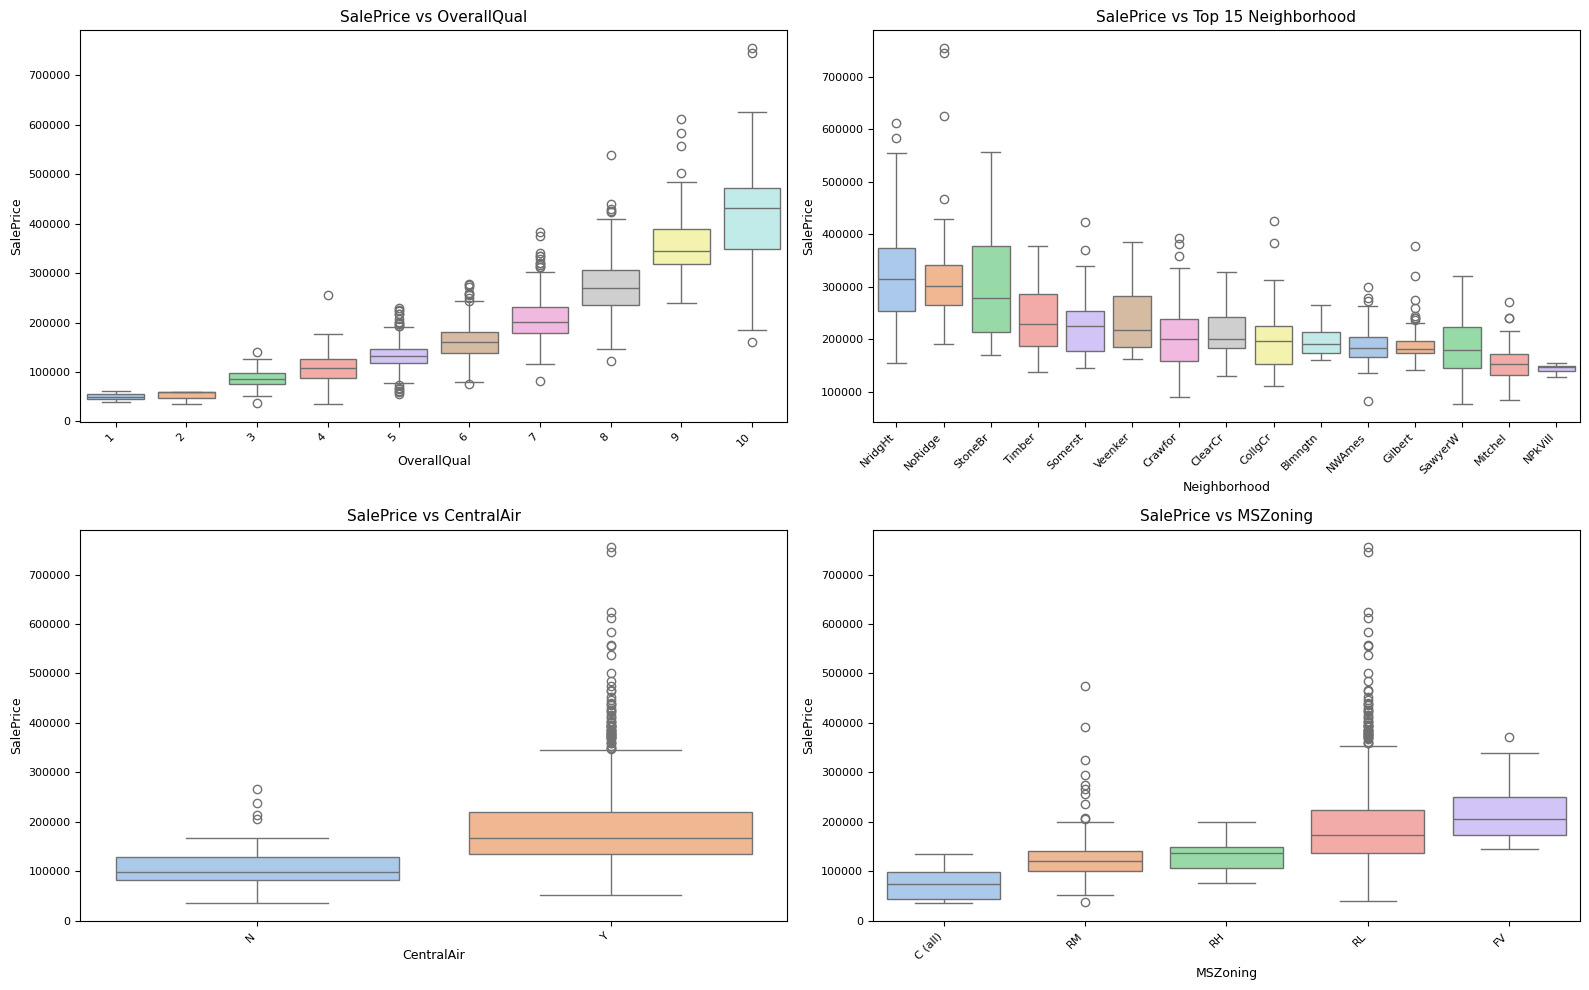

In [38]:
# --- Boxplot SalePrice vs Fitur Kategorikal Pilihan ---
print("--- Boxplot SalePrice vs Fitur Kategorikal Pilihan ---")

categorical_for_boxplot = ['OverallQual', 'Neighborhood', 'CentralAir', 'MSZoning'] # OverallQual adalah numerik tapi bisa diperlakukan sebagai ordinal

plt.figure(figsize=(16, 10))
for i, cat_col in enumerate(categorical_for_boxplot):
    if cat_col in df.columns and TARGET_COL in df.columns:
        plt.subplot(2, 2, i + 1)
        # Jika kategori terlalu banyak, pertimbangkan untuk membatasi atau menggabungkan
        if df[cat_col].nunique() > 15 and cat_col == 'Neighborhood': # Contoh untuk Neighborhood
             order = df.groupby(cat_col)[TARGET_COL].median().sort_values(ascending=False).index[:15] # Ambil top 15
             sns.boxplot(x=cat_col, y=TARGET_COL, data=df[df[cat_col].isin(order)], palette="pastel", order=order)
             plt.title(f'{TARGET_COL} vs Top 15 {cat_col}', fontsize=11)
        else:
             order = df.groupby(cat_col)[TARGET_COL].median().sort_values().index
             sns.boxplot(x=cat_col, y=TARGET_COL, data=df, palette="pastel", order=order)
             plt.title(f'{TARGET_COL} vs {cat_col}', fontsize=11)

        plt.xlabel(cat_col, fontsize=9)
        plt.ylabel(TARGET_COL, fontsize=9)
        plt.xticks(rotation=45, ha='right', fontsize=8)
        plt.yticks(fontsize=8)
    else:
        print(f"Peringatan: Kolom '{cat_col}' atau '{TARGET_COL}' tidak ditemukan.")
plt.tight_layout()
plt.show()

Analisis Boxplot: Boxplot ini akan menunjukkan bagaimana median, kuartil, dan outlier dari SalePrice bervariasi antar kategori. Misalnya, OverallQual (Kualitas Keseluruhan Material dan Finishing) yang lebih tinggi cenderung memiliki SalePrice yang lebih tinggi dan kurang bervariasi.

##### 1.4.3. Hubungan Antar Fitur Numerik dan SalePrice (Scatter Plot)
Scatter plot membantu memvisualisasikan hubungan antara dua variabel numerik. Kita akan melihat hubungan antara GrLivArea (Luas Area Tinggal di Atas Permukaan Tanah) dan TotalBsmtSF (Total Luas Basement) dengan SalePrice, dengan pewarnaan berdasarkan OverallQual untuk melihat interaksi.

--- Scatter Plot Fitur Numerik Pilihan vs SalePrice ---


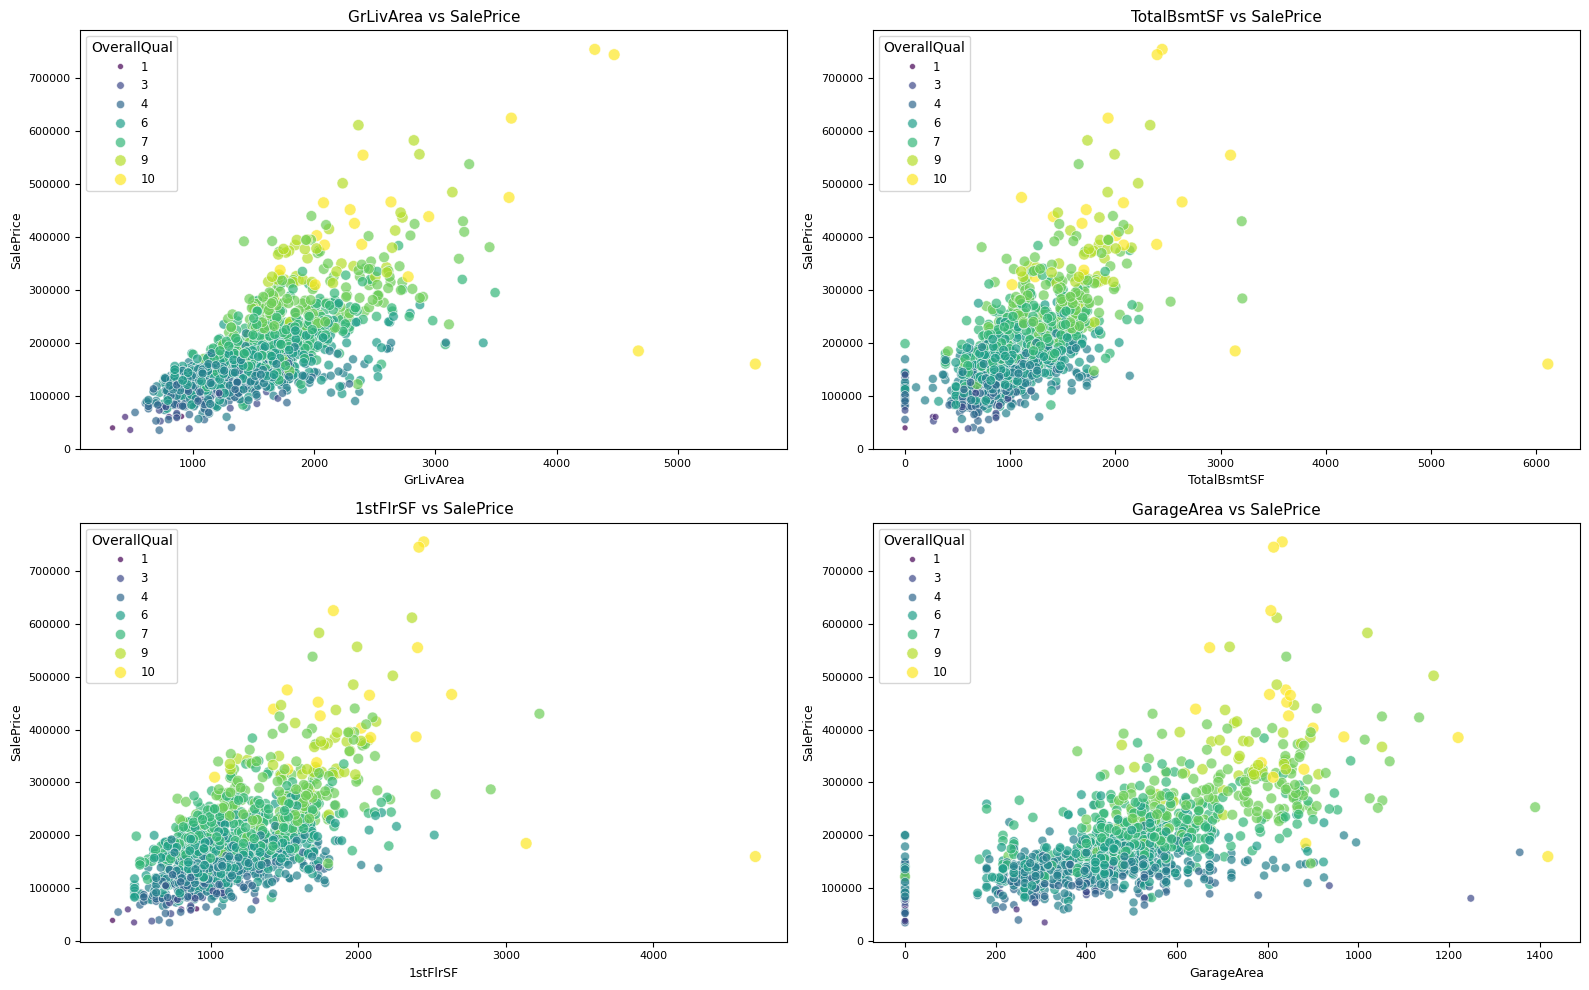

In [39]:
# --- Scatter Plot Fitur Numerik Pilihan vs SalePrice ---
print("--- Scatter Plot Fitur Numerik Pilihan vs SalePrice ---")

numerical_for_scatterplot = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea']

plt.figure(figsize=(16, 10))
for i, num_col in enumerate(numerical_for_scatterplot):
    if num_col in df.columns and TARGET_COL in df.columns:
        plt.subplot(2, 2, i + 1)
        sns.scatterplot(x=num_col, y=TARGET_COL, data=df, hue='OverallQual' if 'OverallQual' in df.columns else None, palette='viridis', alpha=0.7, size='OverallQual' if 'OverallQual' in df.columns else None)
        plt.title(f'{num_col} vs {TARGET_COL}', fontsize=11)
        plt.xlabel(num_col, fontsize=9)
        plt.ylabel(TARGET_COL, fontsize=9)
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        if 'OverallQual' in df.columns:
            plt.legend(title='OverallQual', fontsize='small', loc='upper left')
    else:
         print(f"Peringatan: Kolom '{num_col}' atau '{TARGET_COL}' tidak ditemukan.")
plt.tight_layout()
plt.show()

Analisis Scatter Plot: Plot ini akan menunjukkan tren hubungan. Misalnya, kita mengharapkan hubungan positif antara GrLivArea dan SalePrice (semakin luas area tinggal, semakin mahal rumahnya). Pewarnaan berdasarkan OverallQual dapat menunjukkan apakah rumah dengan kualitas lebih baik memiliki harga yang lebih tinggi pada luas yang sama.

##### 1.4.4. Matriks Korelasi (Heatmap)
Heatmap dari matriks korelasi digunakan untuk melihat kekuatan dan arah hubungan linear antar fitur numerik, termasuk variabel target SalePrice. Ini membantu mengidentifikasi fitur mana yang paling berkorelasi dengan harga dan juga potensi multikolinearitas antar fitur prediktor.

--- Heatmap Korelasi Fitur Numerik (Termasuk Target) ---


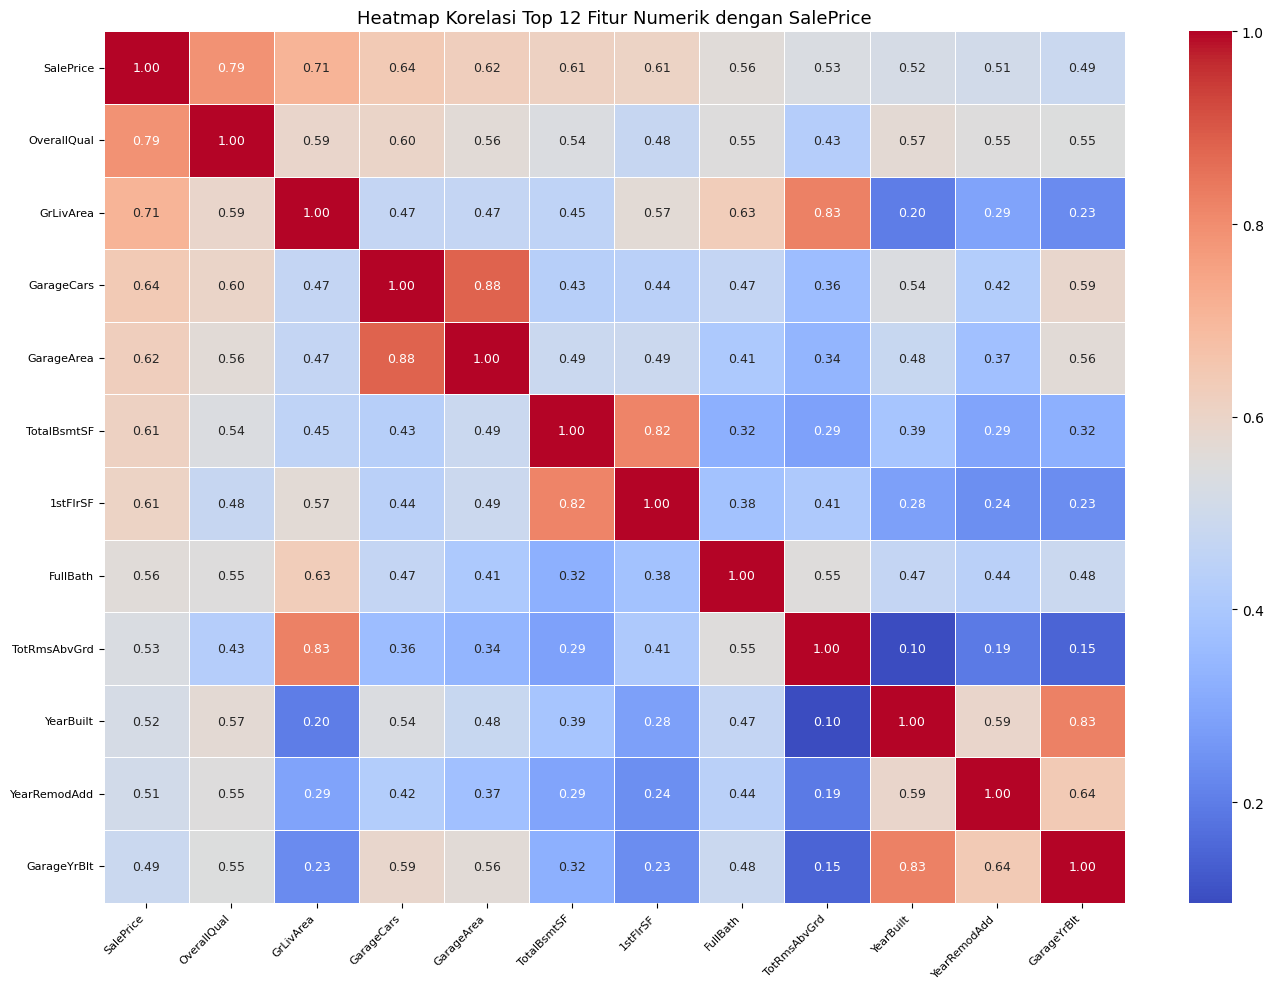

In [40]:
# --- Heatmap Korelasi Fitur Numerik ---
print("--- Heatmap Korelasi Fitur Numerik (Termasuk Target) ---")

# Pilih fitur numerik yang relevan untuk heatmap korelasi
if numerical_features_all and len(numerical_features_all) > 1:
    plt.figure(figsize=(14, 10))
    correlation_matrix_full = df[numerical_features_all].corr()

    n_top_features_corr = 12
    if TARGET_COL in correlation_matrix_full.columns:
        top_corr_features_indices = correlation_matrix_full[TARGET_COL].abs().sort_values(ascending=False).index[:n_top_features_corr]
        correlation_matrix_top_n = df[top_corr_features_indices].corr()
        sns.heatmap(correlation_matrix_top_n, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 9})
        plt.title(f'Heatmap Korelasi Top {n_top_features_corr} Fitur Numerik dengan {TARGET_COL}', fontsize=13)
    else:
        sns.heatmap(correlation_matrix_full, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size":7})
        plt.title('Heatmap Korelasi Fitur Numerik', fontsize=13)

    plt.xticks(fontsize=8, rotation=45, ha='right')
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("Tidak dapat membuat heatmap korelasi karena fitur numerik tidak valid atau tidak cukup (perlu minimal 2).")
print("\n")

Analisis Heatmap Korelasi: Perhatikan fitur-fitur yang memiliki korelasi tinggi (positif atau negatif) dengan SalePrice. Juga, perhatikan korelasi tinggi antar fitur prediktor karena ini bisa menjadi indikasi multikolinearitas.

### 2. Persiapan Data (Data Preparation)
Tahap ini melibatkan transformasi data agar siap digunakan oleh model machine learning.

#### 2.1. Pemisahan Fitur dan Target

In [41]:
# --- 2. Persiapan Data (Data Preparation) ---
print("--- Persiapan Data ---")

if TARGET_COL not in df.columns:
    raise ValueError(f"Kolom target '{TARGET_COL}' tidak ditemukan dalam DataFrame.")

X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]
print(f"Fitur (X) berhasil dipisahkan. Jumlah fitur: {X.shape[1]}")
print(f"Target (y) berhasil dipisahkan. Jumlah sampel: {y.shape[0]}")
print("\n")

--- Persiapan Data ---
Fitur (X) berhasil dipisahkan. Jumlah fitur: 79
Target (y) berhasil dipisahkan. Jumlah sampel: 1460




#### 3.2. Definisi Kolom untuk Preprocessing
Mendefinisikan secara eksplisit mana kolom yang numerik dan mana yang kategorikal untuk diterapkan transformasi yang sesuai.
Kita juga akan menangani missing values di sini.

In [42]:
# --- Definisi Kolom Numerik dan Kategorikal untuk Preprocessing ---
categorical_cols_prep = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols_prep = X.select_dtypes(include=np.number).columns.tolist()

print(f"Jumlah fitur numerik untuk preprocessing: {len(numerical_cols_prep)}")
print(f"Contoh fitur numerik: {numerical_cols_prep[:5]}")
print(f"Jumlah fitur kategorikal untuk preprocessing: {len(categorical_cols_prep)}")
print(f"Contoh fitur kategorikal: {categorical_cols_prep[:5]}")
print("\n")

Jumlah fitur numerik untuk preprocessing: 36
Contoh fitur numerik: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond']
Jumlah fitur kategorikal untuk preprocessing: 43
Contoh fitur kategorikal: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']




#### 2.3. Pembuatan Preprocessor dengan ColumnTransformer
Penjelasan mengenai SimpleImputer, StandardScaler, dan OneHotEncoder serta alasan penggunaannya:

SimpleImputer(strategy='mean') untuk numerik: Mengisi nilai NaN dengan rata-rata kolom. Digunakan karena beberapa fitur numerik mungkin memiliki data hilang, dan rata-rata adalah estimasi sentral yang umum.
StandardScaler() untuk numerik: Menstandarisasi fitur (mean=0, std=1). Penting untuk algoritma yang sensitif terhadap skala fitur (misalnya Regresi Linear, SVM) agar semua fitur memiliki kontribusi yang seimbang.
SimpleImputer(strategy='most_frequent') untuk kategorikal: Mengisi nilai NaN dengan modus (nilai paling sering muncul). Cocok untuk data kategorikal.
OneHotEncoder(handle_unknown='ignore', drop='first') untuk kategorikal: Mengubah kategori menjadi vektor biner. handle_unknown='ignore' mencegah error jika kategori baru muncul di data tes. drop='first' menghindari multikolinearitas.

In [43]:
# --- Pembuatan Preprocessor ---
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols_prep),
        ('cat', categorical_pipeline, categorical_cols_prep)
    ],
    remainder='passthrough'
)
print("Preprocessor berhasil dibuat.")
print("\n")

Preprocessor berhasil dibuat.




#### 2.4. Pembagian Data Latih dan Data Uji
Dataset dibagi menjadi data latih (80%) dan data uji (20%) untuk melatih dan mengevaluasi model secara objektif.

In [44]:
# --- Pembagian Data Latih dan Data Uji ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Jumlah data latih (X_train): {X_train.shape[0]} sampel")
print(f"Jumlah data uji (X_test): {X_test.shape[0]} sampel")
print(f"Jumlah target latih (y_train): {y_train.shape[0]} sampel")
print(f"Jumlah target uji (y_test): {y_test.shape[0]} sampel")
print("\n")

Jumlah data latih (X_train): 1168 sampel
Jumlah data uji (X_test): 292 sampel
Jumlah target latih (y_train): 1168 sampel
Jumlah target uji (y_test): 292 sampel




### 3. Pembuatan Model (Modeling)
Pada tahap ini, kita akan membangun, melatih, dan melakukan *tuning* model *machine learning*.

#### 3.1. Model 1: Regresi Linear (Baseline)
Penjelasan Regresi Linear:

Kelebihan: Sederhana, mudah diinterpretasi, cepat dilatih.
Kekurangan: Asumsi linearitas, sensitif terhadap outliers dan multikolinearitas.

In [45]:
# --- 3. Pembuatan Model (Modeling) ---
print("--- Pembuatan Model ---")

models = {}
evaluation_results = {}

# Model 1: Regresi Linear
print("Melatih Model Regresi Linear...")
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
models['Linear Regression'] = lr_pipeline
y_pred_lr = lr_pipeline.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
evaluation_results['Linear Regression'] = {'MAE': mae_lr, 'MSE': mse_lr, 'RMSE': rmse_lr, 'R2': r2_lr}
print(f"Regresi Linear - MAE: ${mae_lr:,.2f}, MSE: {mse_lr:,.2f}, RMSE: ${rmse_lr:,.2f}, R2: {r2_lr:.4f}")
print("\n")

--- Pembuatan Model ---
Melatih Model Regresi Linear...
Regresi Linear - MAE: $20,111.24, MSE: 2,403,958,950.40, RMSE: $49,030.18, R2: 0.6866




/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


#### 3.2. Model 2: Random Forest Regressor (dengan Hyperparameter Tuning)
Penjelasan Random Forest:

Kelebihan: Akurasi tinggi, menangani non-linearitas, robust outliers, mengurangi overfitting.
Kekurangan: Kompleks, kurang interpretatif, training lebih lama, butuh tuning. Penjelasan GridSearchCV dan parameter yang di-tuning.

In [46]:
# --- Model 2: Random Forest Regressor dengan GridSearchCV ---
print("Melatih Model Random Forest Regressor dengan GridSearchCV...")
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))])

param_grid_rf = {
    'regressor__n_estimators': [100, 150],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 4]
}

grid_search_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf,
                              cv=3, n_jobs=-1, verbose=2, scoring='r2')

grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
models['Random Forest (Tuned)'] = best_rf_model
y_pred_rf_tuned = best_rf_model.predict(X_test)

print(f"Parameter terbaik untuk Random Forest: {grid_search_rf.best_params_}")

mae_rf_tuned = mean_absolute_error(y_test, y_pred_rf_tuned)
mse_rf_tuned = mean_squared_error(y_test, y_pred_rf_tuned)
rmse_rf_tuned = np.sqrt(mse_rf_tuned)
r2_rf_tuned = r2_score(y_test, y_pred_rf_tuned)
evaluation_results['Random Forest (Tuned)'] = {'MAE': mae_rf_tuned, 'MSE': mse_rf_tuned, 'RMSE': rmse_rf_tuned, 'R2': r2_rf_tuned}
print(f"Random Forest (Tuned) - MAE: ${mae_rf_tuned:,.2f}, MSE: {mse_rf_tuned:,.2f}, RMSE: ${rmse_rf_tuned:,.2f}, R2: {r2_rf_tuned:.4f}")
print("\n")

Melatih Model Random Forest Regressor dengan GridSearchCV...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Parameter terbaik untuk Random Forest: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 150}
Random Forest (Tuned) - MAE: $17,856.53, MSE: 829,641,491.96, RMSE: $28,803.50, R2: 0.8918




/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [14, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### 4. Evaluasi dan Pemilihan Model
Performa kedua model dibandingkan menggunakan metrik MAE, MSE, dan R². Model dengan R² tertinggi dan error terendah dipilih sebagai model terbaik.

In [47]:
# --- 4. Evaluasi dan Pemilihan Model ---
print("--- Hasil Evaluasi Model ---")
results_df = pd.DataFrame(evaluation_results).T
results_df['RMSE'] = np.sqrt(results_df['MSE'])
results_df = results_df.sort_values(by=['R2', 'RMSE'], ascending=[False, True])
print(results_df)
print("\n")

if not results_df.empty:
    best_model_name = results_df.index[0]
    best_model_pipeline = models[best_model_name]
    print(f"Model terbaik berdasarkan R2 Score dan RMSE adalah: {best_model_name}")
    print(f"Dengan R2 = {results_df.loc[best_model_name, 'R2']:.4f} dan RMSE = ${results_df.loc[best_model_name, 'RMSE']:,.2f}")
else:
    print("Tidak ada hasil evaluasi model untuk dipilih.")
    best_model_name = "N/A"
    best_model_pipeline = None
print("\n")

--- Hasil Evaluasi Model ---
                                MAE           MSE          RMSE        R2
Random Forest (Tuned)  17856.526102  8.296415e+08  28803.497912  0.891838
Linear Regression      20111.236836  2.403959e+09  49030.184075  0.686590


Model terbaik berdasarkan R2 Score dan RMSE adalah: Random Forest (Tuned)
Dengan R2 = 0.8918 dan RMSE = $28,803.50




### 6. Penyimpanan Model
Model terbaik yang telah dipilih (termasuk *preprocessor*-nya) disimpan ke dalam file menggunakan `joblib` agar dapat digunakan kembali di masa mendatang.

In [48]:
# --- 5. Penyimpanan Model ---
if best_model_pipeline is not None and best_model_name != "N/A":
    model_filename = f'{best_model_name.lower().replace(" ", "_").replace("(", "").replace(")", "")}_house_price_model.joblib'
    joblib.dump(best_model_pipeline, model_filename)
    print(f"Model terbaik ({best_model_name}) telah disimpan sebagai {model_filename}")
else:
    print("Tidak ada model terbaik untuk disimpan.")
print("\n")

Model terbaik (Random Forest (Tuned)) telah disimpan sebagai random_forest_tuned_house_price_model.joblib




### 7. (Opsional) Contoh Pemuatan Model dan Prediksi
Bagian ini mendemonstrasikan cara memuat model yang telah disimpan dan menggunakannya untuk melakukan prediksi pada data sampel baru.

In [49]:
# --- (Opsional) Contoh Pemuatan Model dan Melakukan Prediksi ---
if best_model_pipeline is not None and 'model_filename' in locals() and model_filename is not None :
    print("--- Contoh Pemuatan Model dan Prediksi ---")
    if os.path.exists(model_filename):
        try:
            loaded_model_pipeline = joblib.load(model_filename)
            print(f"Model '{model_filename}' berhasil dimuat.")

            # Membuat contoh data baru
            if X_test.shape[0] >= 2:
                sample_new_data_df = X_test.sample(2, random_state=42).copy()
                print(f"Data sampel yang digunakan untuk prediksi (diambil dari X_test):\n{sample_new_data_df}")
            else:
                print("Tidak cukup data di X_test untuk sampel, buat data sampel manual jika diperlukan.")
                # Contoh data sampel manual jika X_test kosong atau tidak cukup
                sample_new_data_dict_manual = {
                    'MSSubClass': [60, 20], 'MSZoning': ['RL', 'RM'], 'LotFrontage': [65.0, 80.0],
                    'LotArea': [8450, 9600], 'Street': ['Pave', 'Pave'], 'Alley': [np.nan, np.nan],
                    'LotShape': ['Reg', 'IR1'], 'LandContour': ['Lvl', 'Lvl'], 'Utilities': ['AllPub', 'AllPub'],
                    'LotConfig': ['Inside', 'FR2'], 'LandSlope': ['Gtl', 'Gtl'], 'Neighborhood': ['CollgCr', 'Veenker'],
                    'Condition1': ['Norm', 'Feedr'], 'Condition2': ['Norm', 'Norm'], 'BldgType': ['1Fam', '1Fam'],
                    'HouseStyle': ['2Story', '1Story'], 'OverallQual': [7, 6], 'OverallCond': [5, 8],
                    'YearBuilt': [2003, 1976], 'YearRemodAdd': [2003, 1976], 'RoofStyle': ['Gable', 'Gable'],
                    'RoofMatl': ['CompShg', 'CompShg'], 'Exterior1st': ['VinylSd', 'MetalSd'],
                    'Exterior2nd': ['VinylSd', 'MetalSd'], 'MasVnrType': ['BrkFace', 'None'], 'MasVnrArea': [196.0, 0.0],
                    'ExterQual': ['Gd', 'TA'], 'ExterCond': ['TA', 'TA'], 'Foundation': ['PConc', 'CBlock'],
                    'BsmtQual': ['Gd', 'Gd'], 'BsmtCond': ['TA', 'TA'], 'BsmtExposure': ['No', 'Gd'],
                    'BsmtFinType1': ['GLQ', 'ALQ'], 'BsmtFinSF1': [706, 978], 'BsmtFinType2': ['Unf', 'Unf'],
                    'BsmtFinSF2': [0, 0], 'BsmtUnfSF': [150, 284], 'TotalBsmtSF': [856, 1262],
                    'Heating': ['GasA', 'GasA'], 'HeatingQC': ['Ex', 'Ex'], 'CentralAir': ['Y', 'Y'],
                    'Electrical': ['SBrkr', 'SBrkr'], '1stFlrSF': [856, 1262], '2ndFlrSF': [854, 0],
                    'LowQualFinSF': [0, 0], 'GrLivArea': [1710, 1262], 'BsmtFullBath': [1, 0],
                    'BsmtHalfBath': [0, 1], 'FullBath': [2, 2], 'HalfBath': [1, 0],
                    'BedroomAbvGr': [3, 3], 'KitchenAbvGr': [1, 1], 'KitchenQual': ['Gd', 'TA'],
                    'TotRmsAbvGrd': [8, 6], 'Functional': ['Typ', 'Typ'], 'Fireplaces': [0, 1],
                    'FireplaceQu': [np.nan, 'TA'], 'GarageType': ['Attchd', 'Attchd'], 'GarageYrBlt': [2003.0, 1976.0],
                    'GarageFinish': ['RFn', 'RFn'], 'GarageCars': [2, 2], 'GarageArea': [548, 460],
                    'GarageQual': ['TA', 'TA'], 'GarageCond': ['TA', 'TA'], 'PavedDrive': ['Y', 'Y'],
                    'WoodDeckSF': [0, 298], 'OpenPorchSF': [61, 0], 'EnclosedPorch': [0, 0],
                    '3SsnPorch': [0, 0], 'ScreenPorch': [0, 0], 'PoolArea': [0, 0],
                    'PoolQC': [np.nan, np.nan], 'Fence': [np.nan, np.nan], 'MiscFeature': [np.nan, np.nan],
                    'MiscVal': [0, 0], 'MoSold': [2, 5], 'YrSold': [2008, 2007],
                    'SaleType': ['WD', 'WD'], 'SaleCondition': ['Normal', 'Normal']
                }
                sample_new_data_df = pd.DataFrame(sample_new_data_dict_manual, index=[0,1])
                # Pastikan urutan kolom sama dengan X_train
                sample_new_data_df = sample_new_data_df[X_train.columns]


            if not sample_new_data_df.empty:
                try:
                    predictions_new_data = loaded_model_pipeline.predict(sample_new_data_df)
                    print("\nPrediksi untuk data baru:")
                    for i, pred in enumerate(predictions_new_data):
                        print(f"Data ke-{i+1} => Prediksi Harga: ${pred:,.2f}")
                        # Anda bisa menampilkan beberapa fitur kunci dari sample_new_data_df.iloc[i] jika diinginkan
                except Exception as e:
                    print(f"Error saat melakukan prediksi pada data sampel: {e}")
                    print("Pastikan data sampel memiliki format dan kolom yang benar.")
            else:
                print("Tidak ada data sampel yang valid untuk diprediksi.")

        except FileNotFoundError:
            print(f"File model '{model_filename}' tidak ditemukan. Tidak dapat memuat model.")
        except Exception as e:
            print(f"Error saat memuat model atau prediksi: {e}")
else:
    print("Tidak ada model yang disimpan atau nama file model tidak tersedia, contoh pemuatan dilewati.")

print("\n--- Proyek Selesai ---")

--- Contoh Pemuatan Model dan Prediksi ---
Model 'random_forest_tuned_house_price_model.joblib' berhasil dimuat.
Data sampel yang digunakan untuk prediksi (diambil dari X_test):
     MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
417          60       RL         74.0     7844   Pave   NaN      Reg   
775          20       RL        110.0    14226   Pave   NaN      Reg   

    LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
Id                                   ...                                     
417         Lvl    AllPub    Inside  ...           0        0    NaN   NaN   
775         Lvl    AllPub    Corner  ...           0        0    NaN   NaN   

    MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                
417         NaN       0       3    2006        WD         Normal  
775         NaN    